<a href="https://colab.research.google.com/github/nurmuhimawann/Sentiment-Analysis-on-COVID-19-Twitter-Data/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Tweets

## 1. Import Package

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 18.9 MB/s 


In [2]:
!pip install tweepy==3.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
tweepy.__version__

'3.10.0'

In [4]:
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning imports
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import string
import re
from string import punctuation
from collections import Counter

## 2. GET & Explore Data

In [6]:
# Call twitter api keys
consumer_key = 'GCTZ311qVSOFTA6WaYr8kOBpy'
consumer_secret = '9xqIpuzQDZDBq9QBRvMmvqfd7JypN6TpZAETAYPO558v9GW6m8'
access_token = '1453916526-mSyAXo7voiQ2IUGd0sUxqcAB63wCPD9ZInPGS38'
access_secret = 'yTDg7AinKFXtJAWmAOHhOJVKPD0mZw6zKI1RRJPm3gpyg'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [7]:
# Search keywords
tweets = tweepy.Cursor(api.search,q="corona",tweet_mode="extended",since="2020-03-02",lang="id").items(1000)
message,retweet_count,retweet,created_at,user_name,user_id=[],[],[],[],[],[]
count = 0
for tweet in tweets:
    count=count+1
    if hasattr(tweet, 'retweeted_status'):
        message.append(tweet.retweeted_status.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(tweet.retweeted_status.user.screen_name)
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
    else:
        message.append(tweet.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(print(''))
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
# insert tweets to database
for i in range(count):
    data=[message[i], retweet_count[i], retweet[i], created_at[i], user_name[i], user_id[i]]

In [8]:
# make dataframe
df=pd.DataFrame({
    'author':retweet,
    'username':user_name,
    'retweet_count':retweet_count,
    'tweets':message,
    'created_at':created_at
})
df = df.sort_values(['created_at'], ascending=[0])

In [9]:
df.to_csv('tweets.csv')

## 3. Preprocessing Data

### 3.1 Case Folding

In [10]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    return tweet

In [11]:
# clean dataframe's text column
df['tweets'] = df['tweets'].apply(processTweet)
# preview some cleaned tweets
df[['tweets']].head()

,tweets
0,menkes budi gunadi varian corona omicron xbb t...
1,maaf kasar klo ikhlas bilang nder semua org tu...
2,pgl gya kya pakistan haar jssa desh new born k...
3,“serikali ina upotoshaji mkubwa walisema pesa ...
4,“katiba itatakiwa iseme mtu yoyote anayepotosh...


In [12]:
# drop duplicates
df = df.drop_duplicates('tweets')
df.shape

(485, 5)

### 3.2 Case Folding

In [13]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [14]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
 
def stoptweet(tweet):
  tweet = stopword.remove(tweet)
  # replace_list = ['dan', 'yang', 'untuk','dari','ini','dengan','karena','pada','dalam','itu','aku','kamu']
  # tweet = re.sub(r'|'.join(map(re.escape, replace_list)), '', tweet)
  return tweet

In [15]:
df['tweets'] = df['tweets'].apply(stoptweet)
# preview some cleaned tweets
df[['tweets']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweets
0,menkes budi gunadi varian corona omicron xbb t...
1,maaf kasar klo ikhlas bilang nder semua org tu...
2,pgl gya kya pakistan haar jssa desh new born k...
3,“serikali ina upotoshaji mkubwa walisema pesa ...
4,“katiba itatakiwa iseme mtu yoyote anayepotosh...


### 3.3 Stemming

In [16]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [17]:
# helper function to clean tweets
def stemtweet(tweet):
  tweet = stemmer.stem(tweet)
  return tweet

In [18]:
# clean dataframe's text column
df['tweets'] = df['tweets'].apply(stemtweet)
# preview some cleaned tweets
df[['tweets']].head()

,tweets
0,menkes budi gunadi varian corona omicron xbb d...
1,maaf kasar klo ikhlas bilang nder semua org tu...
2,pgl gya kya pakistan haar jssa desh new born k...
3,serikali ina upotoshaji mkubwa walisema pesa c...
4,katiba itatakiwa iseme mtu yoyote anayepotosha...


### 3.4 Tokenizing

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
lst = set(stopwords.words('english'))
lst = [x.strip() for x in lst] 
# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in lst]

# -------------------------------------------

# tokenize message column and create a column for tokens
df['tokens'] = df['tweets'].apply(text_process) # tokenize style 1
df = df[['tweets','tokens']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
df.head()

,tweets,tokens
0,menkes budi gunadi varian corona omicron xbb d...,"[menkes, budi, gunadi, varian, corona, omicron..."
1,maaf kasar klo ikhlas bilang nder semua org tu...,"[maaf, kasar, klo, ikhlas, bilang, nder, semua..."
2,pgl gya kya pakistan haar jssa desh new born k...,"[pgl, gya, kya, pakistan, haar, jssa, desh, ne..."
3,serikali ina upotoshaji mkubwa walisema pesa c...,"[serikali, ina, upotoshaji, mkubwa, walisema, ..."
4,katiba itatakiwa iseme mtu yoyote anayepotosha...,"[katiba, itatakiwa, iseme, mtu, yoyote, anayep..."


## 4. Word Cloud

In [21]:
all_words = []
for line in df['tokens']: 
    all_words.extend(line)  
# create a word frequency dictionary
wordfreq = Counter(all_words)
wordfreq.most_common(10)

[('corona', 473),
 ('virus', 92),
 ('baru', 74),
 ('vaksin', 64),
 ('covid', 61),
 ('varian', 57),
 ('aku', 53),
 ('omicron', 45),
 ('pas', 40),
 ('tubuh', 40)]

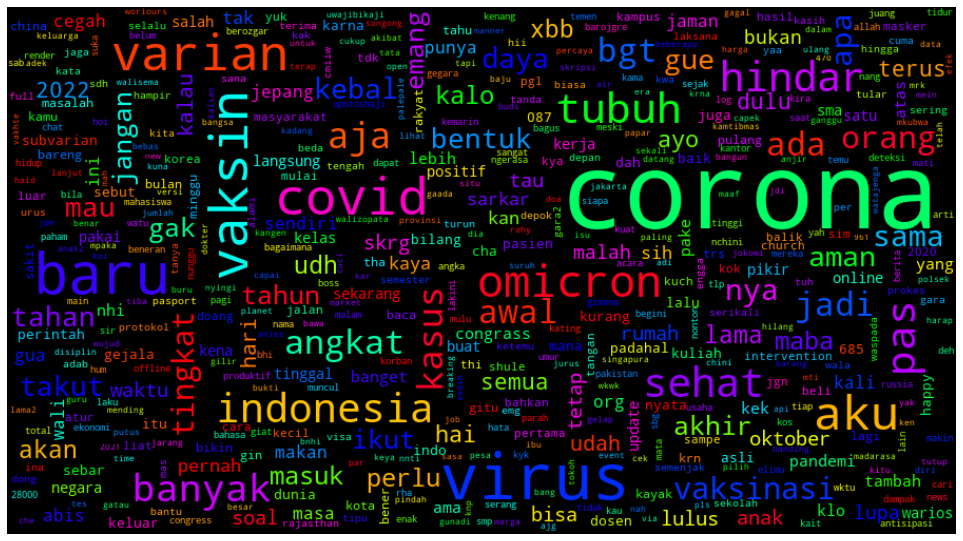

In [22]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='gist_rainbow',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5. Feature Extraction

In [23]:
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['tweets'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))
# example of vectorized text
sample_tweet = df['tweets'][0]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

2978
menkes budi gunadi varian corona omicron xbb deteksi indonesia


  (0, 489)	1
  (0, 582)	1
  (0, 663)	1
  (0, 925)	1
  (0, 1088)	1
  (0, 1752)	1
  (0, 2002)	1
  (0, 2818)	1
  (0, 2932)	1




In [24]:
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df['tweets'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (485, 2978)
Amount of Non-Zero occurences:  6867


In [25]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 2932)	0.30860166800337846
  (0, 2818)	0.23127287545324246
  (0, 2002)	0.2442732476288443
  (0, 1752)	0.44289118470075545
  (0, 1088)	0.2621066534357761
  (0, 925)	0.42196143724888635
  (0, 663)	0.40572706388416296
  (0, 582)	0.07770836118901635
  (0, 489)	0.42196143724888635


In [26]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['covid']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['kasus']])

3.2159167103483717
3.928112085879012


In [27]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(485, 2978)


## 6. Training

In [29]:
data=pd.read_csv("kata.csv", sep=';')
data.head()

,text,label
0,acak-acakan,0
1,adu,0
2,adu domba,0
3,aib,0
4,akal bulus,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Best Model: 0.782692 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}


Mean: 0.782692 Stdev:(0.013086) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.782143 Stdev:(0.013178) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.782418 Stdev:(0.013106) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.782143 Stdev:(0.013178) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.782143 Stdev:(0.013573) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.782143 Stdev:(0.013573) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.782143 Stdev:(0.013573) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': Tru

In [31]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
tn= ['negative', 'positive']

accuracy score:  0.7924407431133889


confusion matrix: 
 [[1050    9]
 [ 315  187]]


              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1059
           1       0.95      0.37      0.54       502

    accuracy                           0.79      1561
   macro avg       0.86      0.68      0.70      1561
weighted avg       0.83      0.79      0.76      1561



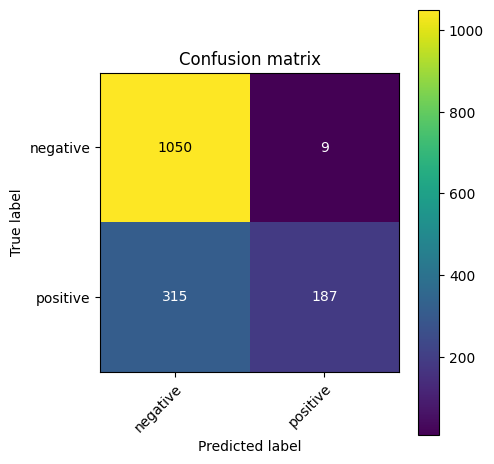

In [32]:
# Confusion Matrix
plt.style.use('default')
def plot_confusion_matrix(y_test, y_pred, classes,
                          title=None,
                          cmap=plt.cm.viridis):

    cm = confusion_matrix(y_test, y_preds)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_preds, classes=tn,
                      title='Confusion matrix')

plt.show()

## 7. Predict

In [33]:
# run predictions on twitter data
tweet_preds = model_NB.predict(df['tweets'])

# append predictions to dataframe
df_tweet_preds = df.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(485, 3)

In [34]:
df_tweet_preds

,tweets,tokens,predictions
0,menkes budi gunadi varian corona omicron xbb d...,"[menkes, budi, gunadi, varian, corona, omicron...",1
1,maaf kasar klo ikhlas bilang nder semua org tu...,"[maaf, kasar, klo, ikhlas, bilang, nder, semua...",1
2,pgl gya kya pakistan haar jssa desh new born k...,"[pgl, gya, kya, pakistan, haar, jssa, desh, ne...",0
3,serikali ina upotoshaji mkubwa walisema pesa c...,"[serikali, ina, upotoshaji, mkubwa, walisema, ...",0
4,katiba itatakiwa iseme mtu yoyote anayepotosha...,"[katiba, itatakiwa, iseme, mtu, yoyote, anayep...",0
...,...,...,...
982,aamiin januari 2020 udah rame corona masih chi...,"[aamiin, januari, 2020, udah, rame, corona, ma...",0
987,angkat corona dong,"[angkat, corona, dong]",0
991,dulu mikir gin pas umur calon gak ada malah co...,"[dulu, mikir, gin, pas, umur, calon, gak, ada,...",0
992,corona bangsat,"[corona, bangsat]",0


In [35]:
pos = df_tweet_preds.predictions.value_counts()[0]
neg = df_tweet_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 139, Negatives - 346


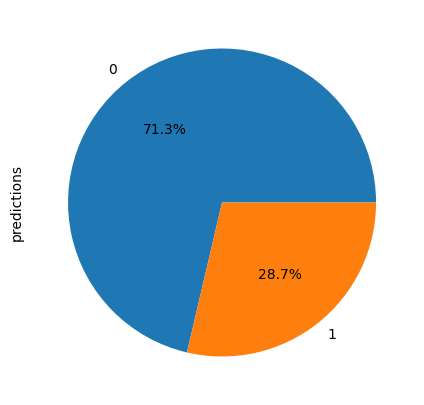

In [36]:
df_tweet_preds['predictions'].value_counts().plot(figsize=(5,5),kind='pie', autopct = "%.1f%%")